# Introduction to Causal Inference with `causallib`

## Summary
This Notebook accompanies the technical workshop on causal inference.
It reviews the estimation methods for causal inference and counterfactual prediction 
and shows how to apply them in `causallib` - an open-source Python package for flexible causal inference modeling.   
The Notebook also contains some blank cells that act as an exercise for those who wish some more hands-on coding.

# Table of Contents
* <a href="#BMD_data">Step 1. Load the Libraries and Pre-Process the Data</a>
    * <a href="#BMD_libraries">Load the libraries</a>
    * <a href="#BMD_load_data">Load the dataset</a>
    * <a href="#BMD_convert">Identify the outcome variable</a>
    * <a href="#BMD_data-treatment">Identify the treatment variable</a>
    * <a href="#BMD_data-confounders">Identify potential confounders</a>
* <a href="#BMD_estimation">Step 2. Estimate the causal effect</a>
    * <a href="#BMD_contact-ipw1">Apply inverse propensity weighting</a>
      * <a href="#BMD_contact-overlap">Overlap validation</a>
      * <a href="#BMD_contact-ipw2">Apply IPW on the overlapping subsample</a>
        * <a href="#BMD_contact-ipw2-eval">Evaluate IPW</a>
        * <a href="#BMD_contact-ipw2-eval">Estimate with IPW</a>
      * <a href="#BMD_contact-ipw-exercise">📖✏️Exercise: try your own IPW🎓</a>
    * <a href="#BMD_contact-standardization">Direct-outcome modeling</a>
      * <a href="#BMD_contact-std-indeffects">Individual-level causal effects</a>
      * <a href="#BMD_contact-std-cate">Conditional average treatment effect</a>
      * <a href="#BMD_contact-std-tlearner">Introducing T-learner</a>
        * <a href="#BMD_contact-std-tlearner-ex">📖✏️Exercise: try your own T-learner🎓</font></a>
    * <a href="#BMD_contact-doublyrobust">Doubly Robust models</a>
      * <a href="#BMD_contact-doublyrobust-ex">📖✏️Exercise: try your own doubly robust🎓</font></a>
* <a href="#BMD_contact-summary">Summary</a>

<a id="BMD_data"></a>
## Step 1. Load the Libraries and Pre-Process Data

<a id="BMD_libraries"></a>
Note, to minimize scrolling, we load here only general purpose libraries and will load the moe specific ones as we progress.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

<a id="BMD_load_data"></a>
### 1.2 Load the dataset

We load the [UCI Bank marketing dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing).

In [2]:
def read_data_from_UCI():
    """Reads the bank-marketing data table from a zip file directly from UCI"""
    import zipfile
    import io
    from urllib import request

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    with request.urlopen(url) as r:
        with zipfile.ZipFile(io.BytesIO(r.read())) as zf:
            csv_file = zf.open("bank-additional/bank-additional-full.csv")
            df = pd.read_csv(csv_file, sep=";")
    return df

data = read_data_from_UCI()
data.shape

(41188, 21)

We list out the variables present in the dataset to understand the contents.

In [3]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

The following are the variables in the [dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing#:~:text=Variables%20Table):
* The first seven variables, *age* through *loan*, are client information, including basic credit characteristics *default*, *housing*, and *loan*.
* The next four variables characterize the client contact during the marketing campaign: the mode of communication, *contact*, which can be "cellular" or "telephone"; the date information, which includes the *month* and the *day_of_week*, and the *duration* of the contact; and *campaign*, the number of contacts made during this campaign.
* The three following variables characterize the previous marketing campaigns, if applicable: the number of days since the last contact from a previous campaign, *pdays*; the number of contacts in previous campaigns, *previous*; and the outcome from the previous campaigns, *poutcome*.
* The variables *emp.var.rate*  and *nr.employed* are economic indicators at the time of the campaign contact representing the employment rate and consumer price index, respectively.
* The last variable *y* is the outcome of the campaign reflecting whether the client opened a term deposit account or not.

<a id="BMD_convert"></a>
### 1.3 Identify the outcome variable

We start processing by converting the *y*  outcome variable into a binary value, mapping "yes" to a value of 1 and "no" to a value of 0.

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
print(data['y'].unique())

le = LabelEncoder()
y = pd.Series(le.fit_transform(data['y']), name='y')
y.mean()

['no' 'yes']


0.11265417111780131

As we can see from the *y* variable mean, 11.3% of the contacted clients signed up for a term deposit account during this campaign.

<a id="BMD_data-treatment"></a>
### 1.4 Identify the treatment variable

Next, we consider which variables could be regarded as interventions that could be undertaken by bank employees to increase the rate of positive outcomes. The interventions are limited to variables associated with the current campaign, since client characteristics and economic conditions cannot be controlled by the bank, nor can past events be changed. In addition, the *duration* is not known until the last contact is completed and is mostly determined by the client, as further discussed [here](https://archive.ics.uci.edu/dataset/222/bank+marketing#:~:text=Variables%20Table).

Of the remaining variables, we will investigate the effects of the mode of communication (*contact*).
We again encode it numerically, with 0 for cellular for 1 for landline telephone.

In [6]:
print(data['contact'].unique())
a = pd.Series(le.fit_transform(data['contact']), name='a')
a.mean()

['telephone' 'cellular']


0.3652520151500437

As we can see by the mean calculated in the following cell, 36.5% of the calls were made to a cellular phone.

<a id="BMD_data-confounders"></a>
### 1.5 Identify potential confounders

To estimate causal effects from observational data, we must identify which of the variables are potential confounders. Confounders are variables that could affect both the outcome variable *y* as well as the decision to intervene *a*. 
We will want to adjust for these confounders to eliminate their impact on the outcome and thus isolate the causal effect of the intervention on the outcome.   

This is a very important task that cannot be validated with data, and thus often relies on domain expert knowledge.  
However, there are several rules of thumbs that usually hold:
1. Avoid adjusting for post-intervention variables. variables downstream of the intervention may "explain away" the treatment effect, biasing the estimation towards the null. Working with such mediator variables brings further complexity to the study design and analysis and is out of scope for this exercise.  
2. It is often useful to view these decisions from the perspective of whoever delivering the interventions (e.g., the bank employee who made the decision) as they can be solicited to understand the factors leading up to their own decision (as opposed to try understand the mechanism determining the outcome and what  factors they include).
3. Factors predicting the outcome but not the treatment, may be beneficial in reducing the outcome variance, leaving variance for the treatment to explain and leading to more precise treatment effect estimations.
4. For a formal enumeration of what covariates should be adjusted for in an analysis, you may refer to [*Cinelli, Forney, and Pearl: A Crash Course in Good and Bad Controls (2022)*](https://doi.org/10.1177/00491241221099). 

With these considerations in mind, we can include the following as potential confounders:
* Client characteristics *age* through *loan*, are factors that clearly affect the outcome, that is, the client's decision to invest in a term deposit. We consider that the bank already has this information in their records and a bank employee could review it before contacting the client.
* Previous campaigns *pdays*, *previous*, and *poutcome* variables indicate the client's previous receptiveness to the bank's products and would also be part of the client record.
* Similarly, *campaign*, the number of contacts up until this point, may also capture relevant informative about a customer's relationship with the bank.
* Economic indicators *emp.var.rate*-*nr.employed* may influence the client's decision as well as the bank's practices.
* and *month* may to account for any seasonal effects.
* Lastly, *duration* (of the call) should be **excluded** since it is future information not available to the banker at the time of the decision (post-treatment information, see first consideration).

In [7]:
confounders = [
    'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'pdays', 'previous', 'poutcome', 'campaign',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
    'month',
]

We extract the confounders into a variable *X* and then in the following cell dummy-code, that converts all of the categorical variables into 1 and 0 values in preparation for modeling.


In [8]:
X = data[confounders]
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
pdays               int64
previous            int64
poutcome           object
campaign            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
month              object
dtype: object

In [9]:
# X = pd.get_dummies(X, prefix_sep='=', drop_first=True)
X = pd.get_dummies(X, drop_first=True)
X.head()

,age,pdays,previous,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,poutcome_success,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,56,999,0,1,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,False,False,False,True,False,False,False
1,57,999,0,1,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,False,False,False,True,False,False,False
2,37,999,0,1,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,False,False,False,True,False,False,False
3,40,999,0,1,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,False,False,False,True,False,False,False
4,56,999,0,1,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,False,False,False,True,False,False,False


<a id="BMD_estimation"></a>
## Step 2. Estimate the causal effect

Before we start with full blown statistical modelling, 
we can first and see what is the unadjusted effect - 
what is the mean outcome in each group without taking confounders into account.

In [10]:
y.groupby(a).mean()

a
0    0.147376
1    0.052313
Name: y, dtype: float64

We see, a pretty large "effect" of 9.5% on average 
in favor of contacting customers through landline rather than on cellular.  
Let's see if this holds when we account for confounding factors.

<a id="BMD_contact-ipw1"></a>
### 2.1 Apply inverse propensity weighting

IPW is probably the most common method for causal inference.
It is used to balance groups by giving each data point a different weight so the weighted distribution of confounding factors is similar across treatment groups. 
In its simplest form, IPW works in two steps:
1. It models the probability of one's treatment assignment as a function of their confounders: $p_i = \Pr[A=a_i|X=x_i]$, commonly referred to as propensity scores.
2. It transforms the probabilities into weights by taking their inverse: $w_i = \frac{1}{p_i}$.

Generally, we can estimate $\Pr[A|X]$ with any estimator that inputs data and outputs a number between 0 and 1,
and `causallib` supports plugging-in any arbitrary such estimators.  
For starters, we will use a logistic regression model the propensity scores.

In [11]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

ipw = IPW(LogisticRegression(penalty='none', max_iter=5000))

We fit the IPW model (which takes care of fitting the internal estimator),
in a very similar manner to how Scikit-learn is designed. 

In [12]:
ipw.fit(X, a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=5000, penalty='none'))

We next estimate the rates of positive outcomes under the two interventions, 0 would have been contacted by landline, and 1 if would have been contacted by cellular phone. 
IPW only supports average (aggregated) outcomes, so this is performed by calling the `estimate_population_outcome` method of the IPW object, similar to how Scikit-learn objects have `predict`.

In [13]:
ipw_outcomes = ipw.estimate_population_outcome(X, a, y)
ipw_outcomes

0    0.155089
1    0.218814
dtype: float64

In [14]:
ipw_outcomes[1] - ipw_outcomes[0]

0.0637247306710714

Wow, this shows an estimated positive outcome of 15.6% and 22.0% for landline and cellular phone, respectively.  
This effect difference is 6.5% is a reversal of the effect relative to the unadjusted calculation above (yielding -9.5%). 
It means we expect that, on average, 6.5 more people who the bank contacts would open a term deposit account if all customers would have been contacted trough their cellular phone instead of a landline.

<a id="BMD_contact-overlap"></a>
### 2.1.1 Overlap validation

*However*, Before we can accept these results, we need to check the IPW model for any problems that we can detect with the observed data. We do this using the `causallib`'s evaluation modules, which we run in the next step.

Specifically, lets first test if the two groups are comparable to begin with. 
Since it can be challenging to check whether a high dimensional distribution of confounders of the two groups is similar, we can reduce it to a single-dimension task by examining whether the propensity scores of the two groups overlap.
Namely, whether the distribution $\Pr[A=1|X,A=0]$ is similar to $\Pr[A=1|X,A=1]$.

c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\causallib\evaluation\predictions.py:94: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  evaluated_metrics_df = evaluated_metrics_df.apply(


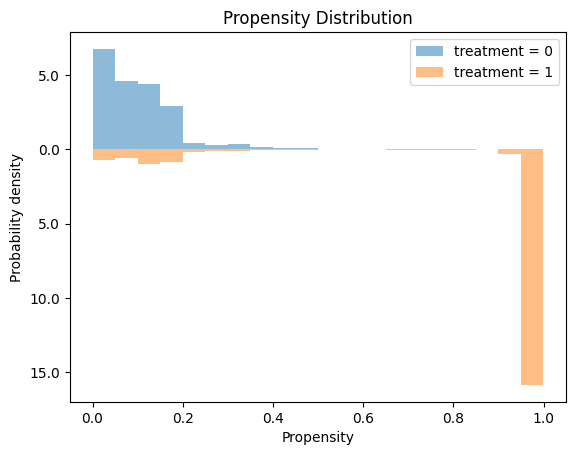

In [15]:
from causallib.evaluation import evaluate

ipw_eval = evaluate(ipw, X, a, y)
ax = ipw_eval.plot_weight_distribution()

This is poor overlap.  
We can see that there is an entire subgroup of treated individuals on the right of the plot that is almost guaranteed to be contacted by cellular phone and have no comparable subgroup from the landline group.

To deal with that, we will focus only on the overlapping region on the left of the distribution where the propensity score is below ~0.3 (we are just eyeballing it at the moment, but there do exist more rigorous ways to do this type of filtering). 

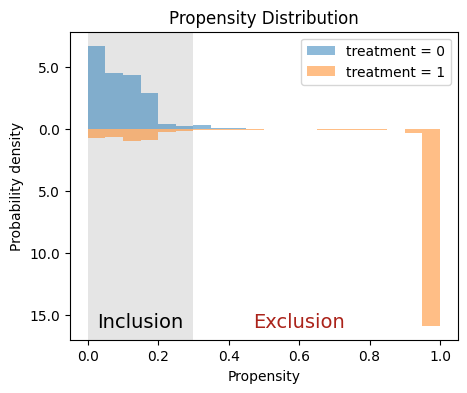

In [16]:
ax.axvspan(0, 0.3, facecolor="0.8", alpha=0.5, zorder=0)
ax.text(0.15, -16, "Inclusion", ha="center", fontsize=14)
ax.text(0.6, -16, "Exclusion", ha="center", fontsize=14, color="#ab231a")
ax.get_figure().set_size_inches(5, 4)
ax.get_figure()

In [17]:
propensity_trim_value = 0.3

propensity_scores = ipw.compute_propensity(X, a)

inclusion_mask = propensity_scores < propensity_trim_value

And now we filter the data to include only overlapping samples

In [18]:
XX = X.loc[inclusion_mask]
aa = a.loc[inclusion_mask]
yy = y.loc[inclusion_mask]
data = data.loc[inclusion_mask]

print(f"Number of samples before overlap filtering: {X.shape[0]}.")
print(f"Number of samples after  overlap filtering: {XX.shape[0]}.")

Number of samples before overlap filtering: 41188.
Number of samples after  overlap filtering: 27777.


<a id="BMD_contact-ipw2"></a>
### 2.1.2 Apply IPW on the overlapping subsample

We now refit the IPW model using the overlapping-only sample

In [19]:
ipw_post_overlap = IPW(LogisticRegression(penalty='none', max_iter=5000))
ipw_post_overlap.fit(XX, aa)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=5000, penalty='none'))

<a id="BMD_contact-ipw2-eval"></a>
##### Evaluate IPW

Now let's use better practices and diagnose our IPW *Before* peeking at what the estimated effect is

In [20]:
ipw_eval = evaluate(ipw_post_overlap, XX, aa, yy)

c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\causallib\evaluation\predictions.py:94: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  evaluated_metrics_df = evaluated_metrics_df.apply(


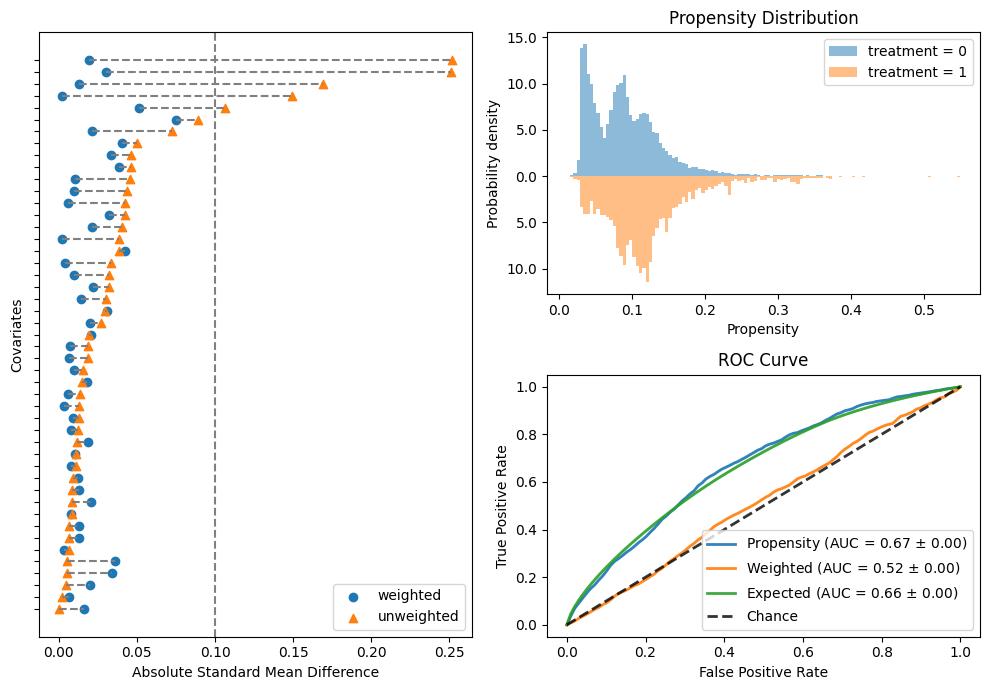

In [21]:
fig, axes = plt.subplot_mosaic(
    '''
    AB
    AC
    ''',
    figsize=(10, 7)
)   

ipw_eval.plot_covariate_balance(kind="love", thresh=0.1, ax=axes["A"])
ipw_eval.plot_weight_distribution(ax=axes["B"])
ipw_eval.plot_roc_curve(ax=axes["C"])
fig.tight_layout()

So here is a suite of three diagnostics that show our IPW model is well-behaving.

* **Propensity Distribution** (top-right): We again show the distribution of propensity scores for both treatment groups, but now we see the two distributions share the same support, meaning the two groups are now comparable.
* **ROC Curve** (bottom-right): In normal classification, we want a high area under curve (AUC) value close to 1, but for causal inference, a high AUC indicates that the two treatment groups are too easily separated and therefore not comparable. Propensity model's ROC should be above the diagonal, so that we believe it did capture some patterns in the data but not too much.
Additionally, the *Weighted* curve should ideally align with the diagonal. This is the ROC curve after weighting the data with inverse probability weights. Therefore, under this weighting, the two groups should be indistinguishable and predictive performance should be as good as random (recall an ideal setting is a randomized control trial, in which treatment is given randomly and therefore cannot be predicted). 
* **Covariate Balance** (left): The covariate balance plot, also called a Love plot, displays the *Absolute standardized mean difference* (x-axis) for every covariate (y-axis, covariates' names often appear for large enough plots / few enough covariates).   
As the name suggests, the ASMD is the difference in averages of each covariate between groups:
  <!-- $$ASMD_j = \frac{\bar{x}_j^{(treated)} - \bar{x}_j^{(control)}}{\sqrt{{\hat{\sigma}_j^{(treated)}}^2 + {\hat{\sigma}_j^{(control)}}^2}}$$ -->
  $$ASMD_j = \left\vert \frac{\bar{x}_j \vert_{A=1}- \bar{x}_j\vert_{A=0}}{\sqrt{\hat{\sigma}_j^2\vert_{A=1} + \hat{\sigma}_j^2\vert_{A=0}}} \right\vert$$
  Where $\bar{x}_j \vert_{A=1}$ is the average of feature $x_j$ among those treated, and $\hat{\sigma}_j^2\vert_{A=0}$ is the estimated standard deviation of $x_j$ among the controls.   
  Furthermore, we show the ASMD both for the original data (orange triangles) and the weighted data (blue dots). We see the after weighting, the difference in averages between the groups is smaller and all covariates fall below the (arbitrary, yet accepted) threshold of 0.1 standard deviation that is considered very-well balanced. 

<a id="BMD_contact-ipw2-estimate"></a>
##### Estimate with IPW

Now that we diagnosed our IPW model and are satisfied with it, 
we can move on to estimate the average counterfactual outcomes and the average treatment effect.

In [22]:
ipw_post_overlap_outcomes = ipw_post_overlap.estimate_population_outcome(XX, aa, yy)
ipw_post_overlap_outcomes

0    0.139654
1    0.109457
dtype: float64

In [23]:
ipw_post_overlap_outcomes[1] - ipw_post_overlap_outcomes[0]

-0.030196886688044072

Wow! another effect reversal.
Trimming the non-overlapping samples (overly-biased towards contacting by cellular) has changed the sign of the effect (again).
We now see it is actually 3% change in favor of landline, as opposed to 6.5% for cellular before verifying overlap.  
Recall our original unadjusted estimation was 9.5% in favor of landline contact.
This is a good example of how statistical adjustment can introduce more bias (sign change, as oppose to just change in magnitude) if not done carefully. 

Lets do some variable renamings that will help us later:

In [24]:
X = XX
a = aa
y = yy
ipw = ipw_post_overlap

<a id="BMD_contact-ipw-exercise"></a>
### 2.1.3 Try your own IPW 

<font color="#32a852" size="4pt"> **!! Exercise !!** </font>  📖✏️🎓  
Try your own IPW.  
Recall that you can plug into IPW any arbitrary estimator that inputs data and outputs a scalar value between 0 and 1 (technically speaking, any Python object that implements `fit` and `predict_proba`).  
Use the cells below to 
1. import your favorite classifier (`sklearn` can be useful here) and
2. Plug it into the `IPW` object when initializing it.
3. Fit the `IPW` model (using `X, a, y`),
4. Predict the potential outcomes, and estimate the effect difference.
5. <font color="#bf378d">**Bonus**:</font> evaluate the IPW model using the `evaluate` function
   (hint: try using the `plot_all()` or the tab-completion for more IPW diagnostics not previously shown).

In [25]:
# Import a classifier

# Initialize an IPW object

# Fit the IPW model


In [26]:
# Bonus: evaluate the fitted IPW model


In [27]:
# Estimate the average counterfactual outcomes

# What is the effect difference?

# Bonus: what is the effect ratio?


<a id="BMD_contact-standardization"></a>
### 2.2 Direct-outcome modeling

So far we applied IPW, which is a weight model that models the treatment as a function of the covariates.  
Next we turn to outcome modeling as a second method to estimate the causal effect of contact mode. We will continue to exclude the cellular phone-only group identified to avoid having to extrapolate beyond the data.

Standardization (also known as S-learner) requires a model for estimating the outcome *y* given intervention *a* and confounders *X*. We will use gradient-boosted classification trees as well as the *predict_proba=True* option to focus on predicting probabilities of outcomes ("risk").

In [28]:
from causallib.estimation import Standardization
from sklearn.ensemble import GradientBoostingClassifier

slearner = Standardization(
    GradientBoostingClassifier(),
    predict_proba=True,
)
slearner.fit(X, a, y)

Standardization(encode_treatment=False, predict_proba=True,
                learner=GradientBoostingClassifier())

We have fitted the model and now we can estimate the average potential outcomes.  
(Note that since outcome models predict the outcome, unlike weight models that use the observed outcome, we don't need to pass the `y` - although for the sake of consistent API we can (and it will be ignored, try it!))

In [29]:
slearner_avg_outcomes = slearner.estimate_population_outcome(X, a)
slearner_avg_outcomes

c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


a  y
0  0    0.861270
   1    0.138730
1  0    0.890617
   1    0.109383
dtype: float64

Note `causallib` is quite pedantic and since we estimate the 
probabilities of `y`, we get in return the counterfactual predictions for both $\Pr[Y=1|X,A]$ and $\Pr[Y=0|X,A]$ although we often don't care about the latter, so we discard it:

In [30]:
slearner_avg_outcomes = slearner_avg_outcomes.xs(1, level="y")
slearner_avg_outcomes

a
0    0.138730
1    0.109383
dtype: float64

And lo and behold - perfect agreement with the estimation we had with IPW!  
In setups like causal inference where ground truth is never known, this kind of consistency is reassuring that at-least our results are stable with regards to specific modeling decisions.

<a id="BMD_contact-std-indeffects"></a>
#### 2.2.1 Individual-level causal effects

Above we have replicated the same average treatment effect we got with logistic regression-based IPW with gradient boosting tree based S-learner (`Standardization`). 

While weight-based models are restricted to aggregated effect 
(because they basically do a weighted average of the observed outcome),
outcome models - as they predict the outcome - can further estimate individual-level effects.  
To do that with `causallib` we will use the `estimate_individual_outcome` method, instead of the `estimate_population_outcome` one.

In [31]:
slearner_ind_outcomes = slearner.estimate_individual_outcome(X, a)
print(slearner_ind_outcomes.shape)
slearner_ind_outcomes.head()

(27777, 4)


c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


a             0                   1          
y             0         1         0         1
12137  0.937475  0.062525  0.954443  0.045557
12138  0.941128  0.058872  0.957151  0.042849
12139  0.921560  0.078440  0.941863  0.058137
12140  0.937704  0.062296  0.954614  0.045386
12141  0.936120  0.063880  0.953438  0.046562

We can see the returned value is a DataFrame with the same number of rows as our data, meaning we have an estimate per sample.
However, `causallib` is yet again overly pedantic so it returns us the values for all levels of `y`, which we can easily keep the relevant one (for `y==1`)

In [32]:
slearner_ind_outcomes = slearner_ind_outcomes.xs(1, level="y", axis="columns")
slearner_ind_outcomes.head()

a,0,1
12137,0.062525,0.045557
12138,0.058872,0.042849
12139,0.078440,0.058137
12140,0.062296,0.045386
12141,0.063880,0.046562


Now we have the quantities of interest: 
* $E[Y_i^1=1|X_i]=E[Y_i=1|X_i,A_i=1]$ and 
* $E[Y_i^0=1|X_i]=E[Y_i=1|X_i,A_i=0]$,

and calculating the effect is a matter of taking an arbitrary contrast between these potential outcomes.

In [33]:
slearner_ind_effect = slearner_ind_outcomes[1] - slearner_ind_outcomes[0]
slearner_ind_effect.head()

12137   -0.016969
12138   -0.016023
12139   -0.020303
12140   -0.016910
12141   -0.017318
dtype: float64

And further take arbitrary aggregation of that contrast (e.g., we are no longer bounded to averages, but may also take the median, instead).

In [ ]:
slearner_ind_effect.median()

<a id="BMD_contact-std-cate"></a>
#### 2.2.2 Conditional average treatment effect

It is important to note that the effect estimated on a single observation is
often highly unreliable as its variance is plausibly much larger than the magnitude of the point estimation (variability which we reduce by averaging over when obtaining the average treatment effect).  
However, for large enough datasets, it allows us to slice and aggregate the effect into subgroups of interest.

First, we can see that if we take the average overall, we get the same average effect we got from using `estimate_population_outcome` (well, no surprise there, this is how `causallib` calculates it under the hood).

In [34]:
slearner_ind_effect.mean()

-0.029347024066826075

However now, we can further examine the average effect in different subgroups
since we can aggregate the individual effects as we choose to

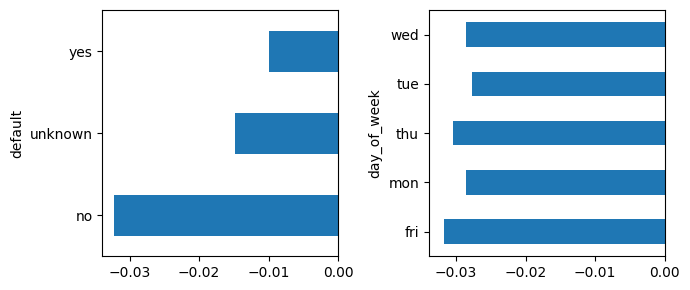

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(7,3), sharex=True)
# fig, axes = plt.subplots(2, 1, figsize=(7,5), sharex=True)
slearner_ind_effect.groupby(data['default']).mean().plot(kind="barh", ax=axes[0])
slearner_ind_effect.groupby(data['day_of_week']).mean().plot(kind="barh", ax=axes[1])
fig.tight_layout()

And we can see that having one's credit defaulted does exhibit some heterogeneity,
while it does not seem to matter on what day did the bank contact its costumers.  
Nonetheless, there is no sign-change in different subgroups, so we may conclude that
it's not the case where subgroups will benefit from different interventions, 
only that some will benefit more and others will benefit less.

<font color="#bf378d" size="3pt">**Bonus exercise**</font>  📖✏️🎓  
play around with other features in `data` (or their combination!) and see whether they exhibit some interesting heterogeneity or not (*extra bonus* for those figuring out what to do with continuous covariates). 

In [36]:
## Uncomment to remind yourself what covairates are available:
## and check out the variable book if needed: https://archive.ics.uci.edu/dataset/222/bank+marketing
# data.columns

In [37]:
# use `slearner_ind_effect` to examine the effect in different strata


To summarize, having individual treatment effects allows us to calculate:
* Arbitrary contrasts (difference, ratio, odds-ratios),
* in arbitrary subgroups,
* using arbitrary aggregation functions (average, median, etc.)

<a id="BMD_contact-std-tlearner"></a>
#### 2.2.3 T-learner

Recall that we have several options to integrate the treatment information in our modeling.    
So far we've use an S-learner ("s" for "single", `Standardization` in `causallib`) that treats the treatment as another variable in the data matrix.  
However, there is also a T-learner ("t" for "two", but it can generalize to arbitrary number of treatment groups) that fits a separate model for each treatment group.
This can better force effect heterogeneity (say, in cases treatment may not be very predictive and therefore be completely ignored by the estimator), but uses a smaller sample size for each model and therefore may be less robust.
T-learners are implemented as `StratifiedStandardization` in `causallib`.

<a id="BMD_contact-std-tlearner-ex"></a>
<font color="#32a852" size="4pt"> **!! Exercise !!** </font>  📖✏️🎓  
Fit your own T-learner.  
`Standardization` and `StratifiedStandardization` share the exact same API and are fully interchangeable, so once you define the latter you can simply repeat the process above.

1. Import `StratifiedStandardization` from `causallib`.
2. *Extra*: you can import your favorite classifier or just used the already imported `GradientBoostingClassifier`
   * Note a classifier is needed since the outcome is binary, if it was continuous we would've needed a regression model.
4. Initialize `StratifiedStandardization`
   * Make sure to set `predict_proba=True`
6. Fit the `StratifiedStandardization` model (using `X, a, y`).
7. Predict the average potential outcomes, and estimate the average effect difference.
8. Predict the individual-level potential outcomes, and estimate the individual-level effect difference.
9. <font color="#bf378d">**Bonus**:</font> compare your individual-level effects with the ones obtained with `Standardization` above (maybe with a scatter plot?). Are they consistent?

In [38]:
from causallib.estimation import StratifiedStandardization
# This is your place to import another machine learning model to use internally:


# Initialize a `StratifiedStandardization` model named `tlearner`:

# Fit the model:


In [39]:
# Estimate aggregated counterfactual outcomes:


In [40]:
# Estimate individual-level counterfactual outcomes:


In [41]:
# Go crazy:




<a id="BMD_contact-doublyrobust"></a>
### 2.3 Doubly Robust models

Recall that instead of choosing to model the treatment *or* the outcome, 
we can also combine the two models into a single model.
There are many approaches to combine the two models and this family compounded models is referred to "doubly robust models".
This is because they have a special property that requires only one of the component models 
(either the weight or outcome models) to be unbiased in order for the combined model to be unbiased.
In a way, doubly robust models give a us a second chance at getting the answer right.

As we mentioned in the talk, there are several approaches for combining treatment and outcome models into a single model,
a lot of them are implemented in `causallib`:
1. `WeightedStandardization`: fits a weighted outcome model weighted by inverse propensity weights.
2. `PropensityFeatureStandardization`: adds a propensity score (or an inverse propensity score) as an additional feature to the outcome model.
   <!-- * Tip: use *feature_type="masked_weight_matrix"* to cover most modeling cases.  -->
4. `AIPW`: Augmented IPW fits an outcome model and then uses IPW to reweigh the residuals and add them to the prediction.
6. `TMLE`: Targeted Maximum Likelihood Estimator fits an outcome model and then re-targets the estimation by regressing the outcome on the inverse propensity score while using the predictions from the outcome model as offset.
   <!-- * Tip: use *reduced=False* if you compare more than 2 treatments. -->

Note `causallib` implements other robust models such as `RLearner` and `XLearner`, but their use is out of scope for now (but please do try this at home). 

In [42]:
from causallib.estimation import TMLE, AIPW, PropensityFeatureStandardization, WeightedStandardization

In [43]:
dr = TMLE(
    outcome_model=Standardization(
        GradientBoostingClassifier(), 
        predict_proba=True
    ),
    # weight_model=IPW(GradientBoostingClassifier()),
    weight_model=IPW(
        LogisticRegression(
            penalty="none", max_iter=5000
        )
    ),
    reduced=False,
    importance_sampling=False,
)
dr.fit(X, a, y)
dr_outcomes = dr.estimate_population_outcome(X, a)
dr_outcomes

c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but TargetMinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\204048756\Miniconda3\envs\mit_ibm_tech_workshop\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\2

a
0    0.139570
1    0.104013
dtype: float64

We can see that this results highly agrees with previous estimations, 
but mostly because we had large agreement between IPW and S-learner to begin with,
so there is not a lot to "correct" in the direction of either models. 

<!-- <font color="#32a852" size="4pt"> **!! Excecise !!** </font>  
Fit your own doubly robust model.  

1. Import a doubly robust model of your choosing.
2. Fondly reminisce those "choose your own adventure" books you liked as a kid.
5. Initialize your doubly robust model
   1. Remember to plug in causallib's outcome model and weight model, not a Scikit-learn.
   2. However, note those outcome and weight models should themselves be initialized with a ML estimator
   3. Confusingly reminisce the movie Inception.
   4. Optional: use the `?` or tab-completion to see what other configuration can be passed to it.
7. Fit the doubly robust model (using `X, a, y`).
8. Predict the average potential outcomes, and estimate the average effect difference.
9. <font color="#bf378d">**Bonus**:</font> compare your effect estimate with the previous ones obtained with `IPW`, `Standardization` or `StratifiedStandardization`. Are they consistent? -->

<a id="BMD_contact-doublyrobust-ex"></a>
<font color="#32a852" size="4pt"> **!! Exercise !!** </font>   📖✏️🎓  
Fit your own doubly robust model.  

1. Take the cell above and copy it below.
2. Tinker it as you wish:
   1. Use a different doubly robust model (or use TMLE, it's great).
   2. Use a T-learner instead of an S-learner (or not).
   3. Use different ML estimator within the outcome model and the weight model (<font color="#bf378d">**Bonus**:</font> build a scikit-learn Pipeline with a Grid Search-based model).
   4. Change different parameters in the doubly robust model initialization to investigate different flavors.
      * use the `?` or tab-completion to see what other configuration can be passed to it.
   6. Fondly reminisce those "choose your own adventure" books you liked as a kid.
7. Fit the doubly robust model (using `X, a, y`).
8. Predict the average potential outcomes, and estimate the average effect difference.
9. <font color="#bf378d">**Bonus**:</font> compare your effect estimate with the previous ones obtained with `TMLE`, `IPW`, `Standardization` or `StratifiedStandardization`. Are they consistent?

In [44]:
# Copy here the cell above to tinker with it:




<a id="BMD_contact-summary"></a>
## 3. Summary

In this demo we went over the basic modelling approaches for causal inference with causallib.
1. We have examined whether the data we have can answer a causal question.
3. We have used IPW to obtain average treatment effects.
4. We have used propensity score models to validate overlap or help us achieve it.
5. We have seen how to diagnose a good IPW model.
6. We have presented direct-outcome modeling.
7. We have seen how these can be used to obtained more granular effect estimations (as opposed to just the average across the entire sample). 
8. We have seen how to model the outcome with an S-learner (which fits a single model with the treatment assignment as a feature) and with a T-learner (which fits a model per treatment group with the treatment assignment as sort of task indicator).
9. We then saw how the two modeling approaches can be combined into one doubly robust model.


#### Take home messages:

1. `causallib` offers a mix-and-match, fully interchangeable design that allow the users to seamlessly increase model complexity.
2. It has a two-stage fit-predict-like design that should feel familiar for scikit-learn users.
3. In terms of modeling, we saw IPW can help us both estimate effect and investigate our dataset. Therefore, it is often beneficial to model the treatment assignment even if we choose to model the effect with direct outcomes as means to get to know your data better. And if you plan to model the outcome directly but already have a weight model, why not combine them into a doubly robust model?


#### What we didn't do:

`causallib` has more capabilities we haven't touched on due to time and scope, but briefly:
1. **Survival analysis**: beyond classification and regression, causallib can also model time-to-event outcomes [with the same interchangeable, scalable, plug-in design we saw so far](https://github.com/IBM/causallib/blob/master/examples/causal_survival_analysis.ipynb).
2. **Confounder selection**: similar to feature selection methods in ML, causallib has variable-selection methods tailored for the causal inference setting. [We even have IBM-developed methods there](https://github.com/IBM/causallib/tree/master/causallib/contrib/shared_sparsity_selection). 
3. **Model selection**: again, similar to how model selection in ML, causallib implements mechanism like sklearn's `GridSearchCV` (or any other sklearn-compatible model selection method) optimizing for causal-specific metrics (like the hyper parameters minimizing ASMD or weighted AUC that were discussed above). 
4. **More causal models**: causallib implements even more causal models we haven't discussed: R-learner, X-learner, overlap weights, adversarial balancing, matching...
5. **Out of sample prediction**: following our two-step fit-predict-like approach allows causallib to split the data into train and test (well, train and inference) to get more honest estimations, which is especially important as causallib allows to plug-in arbitrary-complex ML models that may overfit. To see the benefit of properly integrating ensemble learning with causallib, see [this TMLE Notebook](https://github.com/IBM/causallib/blob/master/examples/TMLE.ipynb).


### Take home resources:

1. GitHub repository: [https://github.com/IBM/causallib](https://github.com/IBM/causallib)
2. Usage examples: [https://github.com/IBM/causallib/tree/master/examples](https://github.com/BiomedSciAI/causallib/tree/master/examples)
3. Documentation: [https://causallib.readthedocs.io/en/latest/](https://causallib.readthedocs.io/en/latest/)
4. `pip install causallib`: [https://pypi.org/project/causallib/](https://pypi.org/project/causallib/)